In [0]:
pip3 install tensorflow==2.0.0-beta1

In [0]:
import numpy as np
import re
import itertools
from collections import Counter


positiveDataAddress = './data/rt-polarity.pos'
negativeDataAddress = './data/rt-polarity.neg'

def clean_str(string):
    """
    Tokenization/string cleaning for datasets.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()
  

def load_data_and_labels():
    """
    Loads polarity data from files, splits the data into words and generates labels.
    Returns split sentences and labels.
    """
    # Load data from file
    positive_samples = list(open(positiveDataAddress, 'r', encoding='latin-1').readlines())
    positive_samples = [s.strip() for s in positive_samples]
    negative_samples = list(open(negativeDataAddress, 'r', encoding='latin-1').readlines())
    negative_samples = [s.strip() for s in negative_samples]
    
    # Split by words
    x_text = positive_samples + negative_samples
    x_text = [clean_str(sent) for sent in x_text]
    x_text = [s.split(" ") for s in x_text]
    
    # Generate labels
    positive_labels = [[0, 1] for _ in positive_samples]
    negative_labels = [[1, 0] for _ in negative_samples]
    
    y = np.concatenate([positive_labels, negative_labels], 0)
    
    return [x_text, y]
    
def pad_sentences(sentences, padding_word="<PAD/>"):
    """
    Pads all sentences to the same length. The length is defined by the longest sentence.
    Returns padded sentences.
    """
    sequence_length = max(len(x) for x in sentences)
    print(sequence_length)
    padded_sentences = []
    for i in range(len(sentences)):
        sentence = sentences[i]
        num_padding = sequence_length - len(sentence)
        new_sentence = sentence + [padding_word] * num_padding
        padded_sentences.append(new_sentence)
    return padded_sentences
  
def build_vocab(sentences):
    """
    Builds a vocabulary mapping from word to index based on the sentences.
    Returns vocabulary mapping and inverse vocabulary mapping.
    """
    # Build vocabulary
    word_counts = Counter(itertools.chain(*sentences))
    
    # Mapping from index to word
    vocabulary_inv = [x[0] for x in word_counts.most_common()]
    vocabulary_inv = list(sorted(vocabulary_inv))
    
    # Mapping from word to index
    vocabulary = {x: i for i, x in enumerate(vocabulary_inv)}
    return [vocabulary, vocabulary_inv]
  
def build_input_data(sentences, labels, vocabulary):
    """
    Maps sentences and labels to vectors based on a vocabulary.
    """
    x = np.array([[vocabulary[word] for word in sentence] for sentence in sentences])
    y = np.array(labels)
    return [x, y]

  
def load_data():
    """
    Loads and preprocessed data for the dataset.
    Returns input vectors, labels, vocabulary, and inverse vocabulary.
    """
    # Load and preprocess data
    sentences, labels = load_data_and_labels()
    sentences_padded = pad_sentences(sentences)
    vocabulary, vocabulary_inv = build_vocab(sentences_padded)
    x, y = build_input_data(sentences_padded, labels, vocabulary)
    return [x, y, vocabulary, vocabulary_inv]

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
print('Load Data...')
x, y, vocabulary, vocabulary_inv = load_data()

Load Data...


In [0]:
x_shape = x.shape

TEST_SPLIT=0.1
VALIDATION_SPLIT=0.2

MAX_SEQUENCE_LENGTH = x_shape[1] # 56
vocabulary_size = len(vocabulary_inv) # 18765
EMBEDDING_DIM = 300
filter_sizes = [3,4,5]
num_filters = 64
drop = 0.2
n_epochs = 100
BATCH_SIZE = 30

In [5]:
print('The number of sentences is :', x_shape[0], ', The lenght of sentences is :', x_shape[1])
print('We have {} words in our sentences'.format(vocabulary_size))

The number of sentences is : 10662 , The lenght of sentences is : 56
We have 18765 words in our sentences


In [6]:
# split data into train and test
    X_train, X_test, y_train, y_test = train_test_split(x, y,
                                                        test_size=TEST_SPLIT,
                                                        random_state=42)

    # split training data into train and validation
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                      test_size=VALIDATION_SPLIT,
                                                      random_state=1)

    n_train_samples = X_train.shape[0]
    n_val_samples = X_val.shape[0]
    n_test_samples = X_test.shape[0]

    print('We have %d TRAINING samples' % n_train_samples)
    print('We have %d VALIDATION samples' % n_val_samples)
    print('We have %d TEST samples' % n_test_samples)

We have 7676 TRAINING samples
We have 1919 VALIDATION samples
We have 1067 TEST samples


In [0]:
inputs = Input(shape=(MAX_SEQUENCE_LENGTH, ), dtype='int32')
embedding = Embedding(input_dim=vocabulary_size, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH)(inputs)
reshape = Reshape((MAX_SEQUENCE_LENGTH, EMBEDDING_DIM, 1))(embedding)

conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], EMBEDDING_DIM), strides=1, padding='valid', kernel_initializer='normal', activation='relu')(reshape)
bn_0 = BatchNormalization()(conv_0)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], EMBEDDING_DIM), strides=1, padding='valid', kernel_initializer='normal', activation='relu')(reshape)
bn_1 = BatchNormalization()(conv_1)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], EMBEDDING_DIM), strides=1, padding='valid', kernel_initializer='normal', activation='relu')(reshape)
bn_2 = BatchNormalization()(conv_2)

maxpool_0 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[0] + 1, 1), padding='valid')(bn_0)
maxpool_1 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[1] + 1, 1), padding='valid')(bn_1)
maxpool_2 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[2] + 1, 1), padding='valid')(bn_2)

concatenated_tensor_1 = keras.layers.concatenate([maxpool_0, maxpool_1, maxpool_2])
flatten_1 = Flatten()(concatenated_tensor_1)
dense_1 = Dense(units=10, activation='tanh')(flatten_1)
dropout_1 = Dropout(drop)(dense_1)

In [0]:
lstm_0 = LSTM(64, return_sequences=True, activation='relu')(embedding)
bn_3 = BatchNormalization()(lstm_0)
lstm_1 = LSTM(32, return_sequences=False, activation='relu')(bn_3)
bn_4 = BatchNormalization()(lstm_1)
dense_2 = Dense(units=10, activation='tanh')(bn_4)
dropout_2 = Dropout(drop)(dense_2)

In [0]:
concatenated_tensor_2 = keras.layers.concatenate([dropout_1, dropout_2])
output = Dense(units=2, activation='softmax')(concatenated_tensor_2)

In [10]:
model = keras.Model(inputs=inputs, outputs=output)
early = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0.003,
                              patience=5,
                              verbose=1, mode='auto')

model.compile(optimizer=keras.optimizers.Adam(lr=0.001),
             loss=keras.losses.BinaryCrossentropy(),
             metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 56)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 56, 300)      5629500     input_1[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 56, 300, 1)   0           embedding[0][0]                  
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 54, 1, 64)    57664       reshape[0][0]                    
______________________________________________________________________________________________

In [11]:
print("Traning Model...")
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=n_epochs,  callbacks=[early,], validation_data=(X_val, y_val))

Traning Model...


W0711 15:04:32.002383 140497379411840 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 7676 samples, validate on 1919 samples
Epoch 1/100
7676/7676 [==============================] - 113s 15ms/sample - loss: 0.6762 - accuracy: 0.6072 - val_loss: 0.6254 - val_accuracy: 0.6321
Epoch 2/100
7676/7676 [==============================] - 107s 14ms/sample - loss: 0.3717 - accuracy: 0.8498 - val_loss: 0.5519 - val_accuracy: 0.7389
Epoch 3/100
7676/7676 [==============================] - 106s 14ms/sample - loss: 0.1350 - accuracy: 0.9554 - val_loss: 0.6180 - val_accuracy: 0.7311
Epoch 4/100
7676/7676 [==============================] - 107s 14ms/sample - loss: 0.0478 - accuracy: 0.9855 - val_loss: 0.8165 - val_accuracy: 0.7275
Epoch 5/100
7676/7676 [==============================] - 107s 14ms/sample - loss: 0.0247 - accuracy: 0.9936 - val_loss: 1.0786 - val_accuracy: 0.7092
Epoch 6/100
7676/7676 [==============================] - 103s 13ms/sample - loss: 0.0194 - accuracy: 0.9941 - val_loss: 0.8978 - val_accuracy: 0.7400
Epoch 7/100
7676/7676 [=============================

In [0]:
model.save('drive/My Drive/Text_Classification/model_one/model.h5')

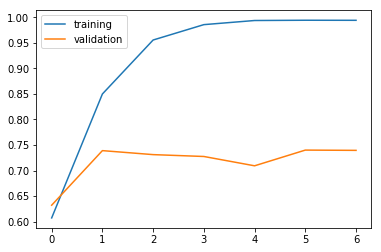

In [13]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

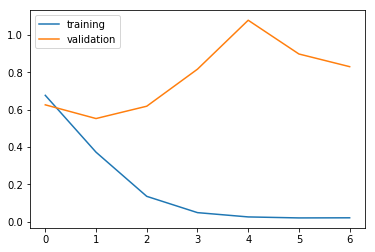

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

In [15]:
res = model.evaluate(X_test, y_test)

1067/1067 [==============================] - 5s 4ms/sample - loss: 0.8944 - accuracy: 0.7366
